In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
# from jupyterthemes import jtplot
# jtplot.reset()

rcParams['figure.figsize'] = [12, 8]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 32

learning_rate = 1e-3
num_epochs = 5

In [6]:
train_dataset = datasets.MNIST('./datas', train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./datas', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Ea(nn.Module):
    def __init__(self, inp_dim, out_dim): # 784 784
        super(Ea, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1000),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(1000, 500),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(500, 250),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(250, 2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(250, 500),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(500, 1000),
#             nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(1000, out_dim),
        )
        
    def forward(self, x):
        outs = self.encoder(x)
        return self.decoder(outs), outs
        
        
        

In [8]:
model = Ea(28 * 28, 28 * 28).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
train_data_count = len(train_dataset)
for epoch in range(num_epochs):
    
    running_loss = .0
    for i, (images, labels) in enumerate(train_loader):
#         images = images.view(batch_size, -1).to(device)
        images = images.view(images.size(0), -1).to(device)
        
        outputs, encoders = model(images)
        
        loss = criterion(outputs, images)
        
        running_loss += loss.item() * img.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print "Epoch: [{}/{}], Step [{}/{}], loss: {:.6f}".format(epoch+1, num_epochs, \
                                                                      (i+1)*images.size(0), train_data_count, \
                                                                      running_loss / (img.size(0) * i))
        
    print "Finish Epoch: [{}/{}]: loss: {:.6f}".format(epoch+1, num_epochs, running_loss / len(train_dataset))
        

Epoch: [1/5], Step [16000/60000], loss: 0.065519
Epoch: [1/5], Step [32000/60000], loss: 0.060780
Epoch: [1/5], Step [48000/60000], loss: 0.057794
Finish Epoch: [1/5]: loss: 0.055788
Epoch: [2/5], Step [16000/60000], loss: 0.045798
Epoch: [2/5], Step [32000/60000], loss: 0.044976
Epoch: [2/5], Step [48000/60000], loss: 0.044224
Finish Epoch: [2/5]: loss: 0.043772
Epoch: [3/5], Step [16000/60000], loss: 0.041475
Epoch: [3/5], Step [32000/60000], loss: 0.041096
Epoch: [3/5], Step [48000/60000], loss: 0.040765
Finish Epoch: [3/5]: loss: 0.040498
Epoch: [4/5], Step [16000/60000], loss: 0.039603
Epoch: [4/5], Step [32000/60000], loss: 0.039431
Epoch: [4/5], Step [48000/60000], loss: 0.039310
Finish Epoch: [4/5]: loss: 0.039119
Epoch: [5/5], Step [16000/60000], loss: 0.038664
Epoch: [5/5], Step [32000/60000], loss: 0.038356
Epoch: [5/5], Step [48000/60000], loss: 0.038411
Finish Epoch: [5/5]: loss: 0.038311


In [10]:
all_encoder = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        outputs, encoders = model(images)
        all_encoder.append([encoders.cpu().data.numpy(), labels.data.numpy()])
    
all_encoder = np.asarray(all_encoder)

In [11]:
encoders = np.concatenate((np.vstack(all_encoder[:,0]), np.hstack(all_encoder[:, 1]).reshape((10000, -1))), axis=1)

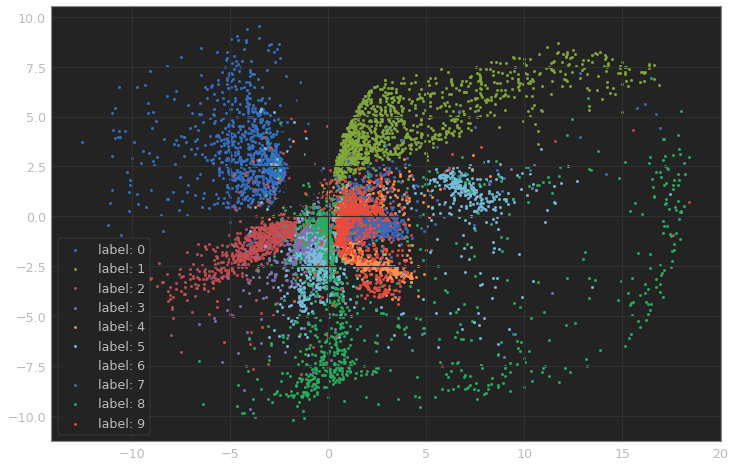

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(10):
    enc = encoders[encoders[:,2] == i]
    ax.scatter(enc[:,0], enc[:,1], label='label: {}'.format(i), marker='.')
    
plt.legend()
plt.show()